# Step1 导入相关库

In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

print("库导入完成！")


使用设备: cpu
库导入完成！


# Step2 数据处理

In [2]:
# 读取数据
train_data = pd.read_csv('data/zgpa_train.csv')
test_data = pd.read_csv('data/zgpa_test.csv')

print("训练数据形状:", train_data.shape)
print("测试数据形状:", test_data.shape)
print("\n训练数据前5行:")
print(train_data.head())
print("\n测试数据前5行:")
print(test_data.head())


训练数据形状: (731, 6)
测试数据形状: (182, 6)

训练数据前5行:
         date   open   high    low  close    volume
0  2016-01-04  30.57  30.57  28.63  28.78  70997200
1  2016-01-05  28.41  29.54  28.23  29.23  87498504
2  2016-01-06  29.03  29.39  28.73  29.26  48012112
3  2016-01-07  28.73  29.25  27.73  28.50  23647604
4  2016-01-08  28.73  29.18  27.63  28.67  98239664

测试数据前5行:
         date   open   high    low  close     volume
0  2019-01-02  54.19  54.33  53.09  53.33   82554240
1  2019-01-03  53.30  54.48  53.21  53.83   69271120
2  2019-01-04  53.43  55.15  53.38  54.74  112985584
3  2019-01-07  55.24  55.32  54.05  54.45   76593008
4  2019-01-08  54.20  54.24  53.35  53.95   55992092


In [3]:
# 数据预处理
def preprocess_data(data):
    # 转换日期格式
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values('date')
    
    # 选择特征
    features = ['open', 'high', 'low', 'close', 'volume']
    
    return data[features].values

# 预处理训练和测试数据
train_features = preprocess_data(train_data)
test_features = preprocess_data(test_data)

print("训练特征形状:", train_features.shape)
print("测试特征形状:", test_features.shape)


训练特征形状: (731, 5)
测试特征形状: (182, 5)


In [4]:
# 数据标准化
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_features)
test_scaled = scaler.transform(test_features)

print("标准化后的训练数据形状:", train_scaled.shape)
print("标准化后的测试数据形状:", test_scaled.shape)


标准化后的训练数据形状: (731, 5)
标准化后的测试数据形状: (182, 5)


In [5]:
# 创建时间序列数据集类
class StockDataset(Dataset):
    def __init__(self, data, seq_length=60):
        self.data = data
        self.seq_length = seq_length
        
    def __len__(self):
        return len(self.data) - self.seq_length
    
    def __getitem__(self, idx):
        # 输入序列：前seq_length天的所有特征
        x = self.data[idx:idx + self.seq_length]
        # 目标：下一天的收盘价（第3列，索引为3）
        y = self.data[idx + self.seq_length, 3]
        
        return torch.FloatTensor(x), torch.FloatTensor([y])

# 设置序列长度
seq_length = 60

# 创建数据集
train_dataset = StockDataset(train_scaled, seq_length)
test_dataset = StockDataset(test_scaled, seq_length)

# 创建数据加载器
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"训练数据集大小: {len(train_dataset)}")
print(f"测试数据集大小: {len(test_dataset)}")
print(f"批次大小: {batch_size}")


训练数据集大小: 671
测试数据集大小: 122
批次大小: 32


# Step3 模型定义

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

# 定义LSTM模型
class LSTM(nn.Module):
    def __init__(self, input_size=5, hidden_size=50, num_layers=2, dropout=0.2):
        super(LSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM层
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout)
        
        # 全连接层
        self.fc1 = nn.Linear(hidden_size, 25)
        self.fc2 = nn.Linear(25, 1)
        
        # Dropout层
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # 初始化隐藏状态和细胞状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # LSTM前向传播
        out, _ = self.lstm(x, (h0, c0))
        
        # 取最后一个时间步的输出
        out = out[:, -1, :]
        
        # 全连接层
        out = self.dropout(out)
        out = torch.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

# 创建模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTM(input_size=5, hidden_size=50, num_layers=2, dropout=0.2)
model = model.to(device)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("LSTM模型创建完成！")
print(f"模型参数数量: {sum(p.numel() for p in model.parameters()):,}")


LSTM模型创建完成！
模型参数数量: 33,101


# Step4模型训练

In [7]:
# 训练函数
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50):
    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        train_loss = 0.0
        
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            # 前向传播
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            
            # 反向传播
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # 验证阶段
        model.eval()
        test_loss = 0.0
        
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                test_loss += loss.item()
        
        # 计算平均损失
        avg_train_loss = train_loss / len(train_loader)
        avg_test_loss = test_loss / len(test_loader)
        
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}')
    
    return train_losses, test_losses

# 开始训练
print("开始训练模型...")
train_losses, test_losses = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50)
print("训练完成！")


开始训练模型...
Epoch [10/50], Train Loss: 0.008001, Test Loss: 0.033155
Epoch [20/50], Train Loss: 0.006772, Test Loss: 0.026954
Epoch [30/50], Train Loss: 0.005865, Test Loss: 0.022422
Epoch [40/50], Train Loss: 0.005160, Test Loss: 0.037594
Epoch [50/50], Train Loss: 0.004013, Test Loss: 0.018607
训练完成！


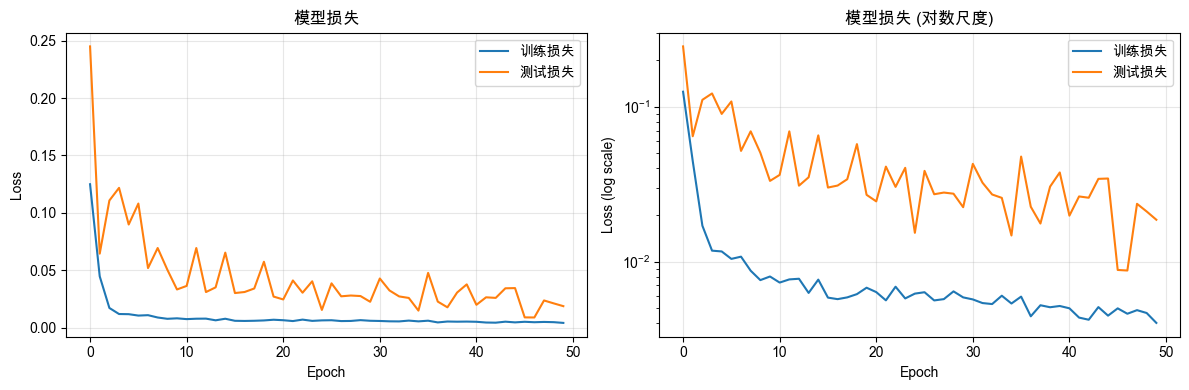

In [8]:

# 绘制训练历史
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='训练损失')
plt.plot(test_losses, label='测试损失')
plt.title('模型损失')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='训练损失')
plt.plot(test_losses, label='测试损失')
plt.title('模型损失 (对数尺度)')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Step5 模型预测

In [9]:
# 预测函数
def predict(model, data_loader):
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(batch_y.cpu().numpy())
    
    return np.array(predictions), np.array(actuals)

# 进行预测
train_predictions, train_actuals = predict(model, train_loader)
test_predictions, test_actuals = predict(model, test_loader)

print(f"训练预测形状: {train_predictions.shape}")
print(f"测试预测形状: {test_predictions.shape}")


训练预测形状: (671, 1)
测试预测形状: (122, 1)


In [10]:
# 反标准化预测结果
def inverse_transform_predictions(predictions, scaler, feature_index=3):
    # 创建一个与原始数据相同形状的数组
    dummy_array = np.zeros((len(predictions), 5))
    dummy_array[:, feature_index] = predictions.flatten()
    
    # 反标准化
    inverse_array = scaler.inverse_transform(dummy_array)
    
    return inverse_array[:, feature_index]

# 反标准化训练和测试数据
train_actual = inverse_transform_predictions(train_actuals, scaler)
train_pred = inverse_transform_predictions(train_predictions, scaler)

test_actual = inverse_transform_predictions(test_actuals, scaler)
test_pred = inverse_transform_predictions(test_predictions, scaler)

print("反标准化完成！")


反标准化完成！


In [11]:
# 计算评估指标
def calculate_metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    
    return mse, mae, rmse

# 计算训练集指标
train_mse, train_mae, train_rmse = calculate_metrics(train_actual, train_pred)

# 计算测试集指标
test_mse, test_mae, test_rmse = calculate_metrics(test_actual, test_pred)

print("=== 模型评估指标 ===")
print(f"训练集 - MSE: {train_mse:.4f}, MAE: {train_mae:.4f}, RMSE: {train_rmse:.4f}")
print(f"测试集 - MSE: {test_mse:.4f}, MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}")


=== 模型评估指标 ===
训练集 - MSE: 2.8424, MAE: 1.2293, RMSE: 1.6859
测试集 - MSE: 48.2307, MAE: 6.5630, RMSE: 6.9448


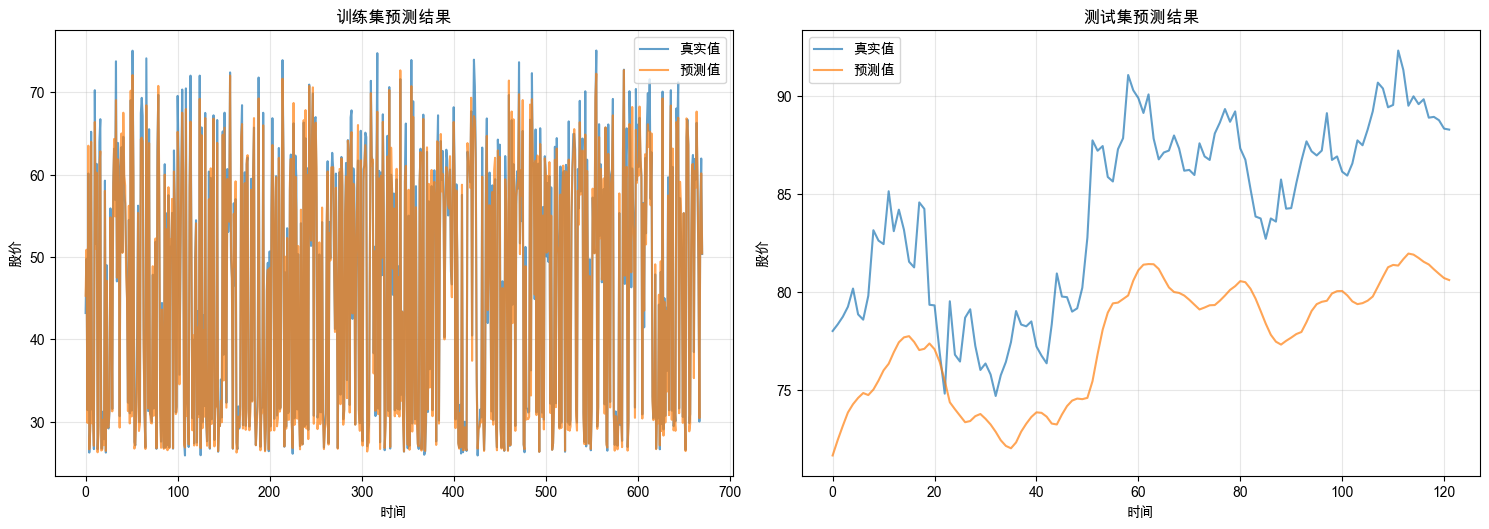

In [12]:
# 可视化预测结果
plt.figure(figsize=(15, 10))

# 训练集预测结果
plt.subplot(2, 2, 1)
plt.plot(train_actual, label='真实值', alpha=0.7)
plt.plot(train_pred, label='预测值', alpha=0.7)
plt.title('训练集预测结果')
plt.xlabel('时间')
plt.ylabel('股价')
plt.legend()
plt.grid(True, alpha=0.3)

# 测试集预测结果
plt.subplot(2, 2, 2)
plt.plot(test_actual, label='真实值', alpha=0.7)
plt.plot(test_pred, label='预测值', alpha=0.7)
plt.title('测试集预测结果')
plt.xlabel('时间')
plt.ylabel('股价')
plt.legend()
plt.grid(True, alpha=0.3)



plt.tight_layout()
plt.show()
